In [1]:
# Packages

# To make data frames
import pandas as pd

# To make plots
import matplotlib.pyplot as plt
import seaborn as sns

# Date arithmetic
from datetime import datetime

# For making arrays
import numpy as np

In [2]:
# Load cleaned data

df_cleaned = pd.read_csv("df_cleaned.csv", parse_dates=['end_date'])

In [3]:
# Get the weights

# Model

trump_pred_pct = df_cleaned['model'][round(len(df_cleaned)/2)-1]
harris_pred_pct = df_cleaned['model'][len(df_cleaned)-1]
total_pct = trump_pred_pct + harris_pred_pct
trump_adj_pct = trump_pred_pct/total_pct
harris_adj_pct = harris_pred_pct/total_pct

# Baseline

trump_b_pct = df_cleaned['drift_pred'][round(len(df_cleaned)/2)-1]
harris_b_pct = df_cleaned['drift_pred'][len(df_cleaned)-1]
total_b_pct = trump_b_pct + harris_b_pct
trump_adj_b_pct = trump_b_pct/total_b_pct
harris_adj_b_pct = harris_b_pct/total_b_pct

In [4]:
# Function that tallies up the swing state votes

latest_date = pd.Timestamp.today().date() # 5 Nov

def tally(trump_adj, harris_adj):
    #print("trump_adj is "+str(trump_adj))
    #print("harris_adj is "+str(harris_adj))
    total = 93
    trump_won = 219 # safe electoral votes
    harris_won = 226 # safe electoral votes
    trump_raw_swing_votes = round(trump_adj*total)
    harris_raw_swing_votes = round(harris_adj*total)
    trump_states = []
    harris_states = []
    states_dict = {'AZ': 11, 'GA': 16, 'NC': 16, 'NV': 6, 'PA': 19, 'WI': 10, 'MI': 15} # as of 5 Nov
    for key in states_dict:
        #print("State is "+key) # for debugging
        votes = states_dict.get(key)
        #print(str(votes)+" votes") # for debugging
        #print("Remaining Trump swing votes: "+str(trump_raw_swing_votes)) # for debugging
        if votes < trump_raw_swing_votes:
            #print("Trump gets more swing votes added.") # for debugging
            trump_raw_swing_votes = trump_raw_swing_votes - votes
            #print("Now remaining Trump swing votes: "+str(trump_raw_swing_votes)) # for debugging
            trump_won = trump_won + votes
            #print("Trump has a total of "+str(trump_won)+" votes") # for debugging
            trump_states.append(key)
            #print("So far Trump has won "+str(trump_states)) # for debugging
        elif trump_raw_swing_votes > 0:
            #print("Now Trump has fewer than the next swing state's votes.") # for debugging
            if trump_raw_swing_votes/votes >= 0.5:
                #print("But he has the majority of them.") # for debugging
                trump_won = trump_won + votes
                #print("Now Trump has "+str(votes)+" total votes") # for debugging
                trump_states.append(key)
                #print("He's wons "+str(trump_states)) # for debugging
            else: 
                #print("Trump doesn't win this state.") # for debugging  
                #print("Harris has "+str(harris_won)+" votes so far.") # for debugging
                harris_won = harris_won + votes
                #print("Now she has "+str(harris_won)+" total votes.") # for debugging
                harris_states.append(key)
                #print("And she's won "+str(harris_states)) # for debugging 
            trump_raw_swing_votes = 0
            #print("Now Trump has "+str(trump_raw_swing_votes)+" left") # for debugging
        else:
            #print("This time Trump has no more swing votes.") # for debugging
            #print("Harris has "+str(harris_won)+" votes so far.") # for debugging
            harris_won = harris_won + votes
            #print("Now she has "+str(harris_won)+" total votes.") # for debugging
            harris_states.append(key)
            #print("And she's won "+str(harris_states)) # for debugging
    print("Trump won "+str(trump_states)+" for a total of "+str(trump_won)+" votes.")
    print("Harris won "+str(harris_states)+" for a total of "+str(harris_won)+" votes.")        

In [5]:
# Tally the votes for my forecast
 
tally(trump_adj_pct, harris_adj_pct)    

Trump won ['AZ', 'GA', 'NC', 'NV'] for a total of 268 votes.
Harris won ['PA', 'WI', 'MI'] for a total of 270 votes.


In [6]:
# Tally the votes for the baseline forecast
 
tally(trump_adj_b_pct, harris_adj_b_pct)     

Trump won ['AZ', 'GA', 'NC', 'NV'] for a total of 268 votes.
Harris won ['PA', 'WI', 'MI'] for a total of 270 votes.


In [7]:
# # Create a df for the previous forecasts (only need to do this once)

# columns = ['date', 'candidate', 'model', 'baseline', 'election_winner_model', 'election_winner_bl']
# previous = pd.DataFrame(columns=columns)
# dates = pd.Series(pd.date_range(start=datetime(2024, 10, 22), end=datetime(2024, 11, 5))).dt.date
# previous['date'] = pd.concat([dates, dates])
# previous['candidate'] = pd.concat([pd.Series("Donald Trump", index=range(len(dates))),
#                                    pd.Series("Kamala Harris", index=range(len(dates)))])
# previous.to_csv("previous.csv", index=False)

In [8]:
# Load the df, add today's numbers manually, save

# As of 5 Nov

previous = pd.read_csv("previous.csv", parse_dates=True)
previous['date'] = pd.to_datetime(previous['date']).dt.date

# Numbers

previous.loc[(previous['date'] == latest_date) 
             & (previous['candidate'] == "Donald Trump"), ['model', 'baseline']] = [trump_pred_pct, trump_b_pct]
previous.loc[(previous['date'] == latest_date) 
             & (previous['candidate'] == "Kamala Harris"), ['model', 'baseline']] = [harris_pred_pct, harris_b_pct]

# Winner (538) 5 Nov

trump_chance = 0.503
harris_chance = 0.495

if trump_chance > harris_chance:
    previous.loc[(previous['date'] == latest_date) 
             & (previous['candidate'] == "Donald Trump"), 'election_winner_538'] = trump_pred_pct
elif harris_chance > trump_chance:
    previous.loc[(previous['date'] == latest_date) 
              & (previous['candidate'] == "Kamala Harris"), 'election_winner_538'] = harris_pred_pct

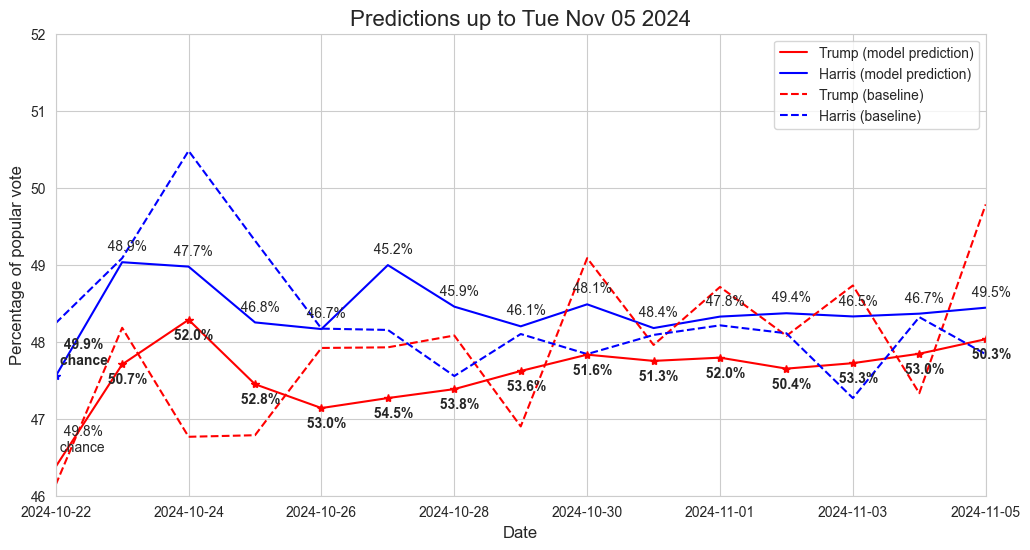

In [11]:
# Plot the data 

## Here's our data
x = pd.Series(pd.date_range(start=datetime(2024, 10, 22), end=datetime(2024, 11, 5))).dt.date
y_trump_mod = previous.loc[previous['candidate'] == "Donald Trump", 'model']
y_trump_baseline = previous.loc[previous['candidate'] == "Donald Trump", 'baseline']
y_harris_mod = previous.loc[previous['candidate'] == "Kamala Harris", 'model']
y_harris_baseline = previous.loc[previous['candidate'] == "Kamala Harris", 'baseline']
y_trump_win_538 = previous.loc[previous['candidate'] == "Donald Trump", 'election_winner_538']
y_harris_win_538 = previous.loc[previous['candidate'] == "Kamala Harris", 'election_winner_538']

## Run this code
sns.set_style("whitegrid")

## plt.figure() will make the figure object
## figsize can control how large it is (width,height)
## here we make a 6 x 4 window
plt.figure(figsize=(12, 6))

## The third argument to plot(), 'mp' here
## tells matplotlib to make the points magenta
## and to use pentagrams, the absence of a line character
## means there will be no line connecting these points
## we can also add a label, and insert a legend later
plt.plot(x, y_trump_mod, 'r', label="Trump (model prediction)")
plt.plot(x, y_harris_mod, 'b', label="Harris (model prediction)")
plt.plot(x, y_trump_baseline, 'r--', label="Trump (baseline)")
plt.plot(x, y_harris_baseline, 'b--', label="Harris (baseline)")
plt.plot(x, y_trump_win_538, 'r*')
plt.plot(x, y_harris_win_538, 'b*')

## we can add axis labels
## and control their fontsize
## A good rule of thumb is the bigger the better
## You want your plots to be readable
## As a note: matplotlib can use LaTeX commands
## so if you place math text in dollar signs it will
## be in a LaTeX environment
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage of popular vote", fontsize=12)

## we can set the plot axis limits like so
## This makes the x axis bounded between -20 and 20
plt.xlim(datetime(2024, 10, 22), datetime(2024, 11, 5))

# Set the x-axis starting tick
plt.xticks([datetime(2024, 10, 22), datetime(2024, 10, 24), datetime(2024, 10, 26), 
                  datetime(2024, 10, 28), datetime(2024, 10, 30), datetime(2024, 11, 1), 
                  datetime(2024, 11, 3), datetime(2024, 11, 5)])

## this makes the y axis bounded between -100 and 100
plt.ylim(46, 52)

## Also a title
## again make it large font
plt.title("Predictions up to "+str(latest_date.strftime('%a %b %d %Y')), fontsize=16) # 2 Nov


## plt.legend() adds the legend to the plot
## This will display the labels we had above
plt.legend()

# Annotate the point (2, 4)
plt.annotate("  49.8% \n chance", 
             xy=(datetime(2024, 10, 22), y_trump_mod[0]), 
             xytext=(datetime(2024, 10, 22)+pd.Timedelta(hours=0), y_trump_mod[0]+0.2))
plt.annotate("  49.9% \n chance", 
             xy=(datetime(2024, 10, 22), y_harris_mod[15]), 
             xytext=(datetime(2024, 10, 22)+pd.Timedelta(hours=0), y_harris_mod[15]+0.15), fontweight='bold')
plt.annotate("  50.7%",# \n chance", 
             xy=(datetime(2024, 10, 23), y_trump_mod[1]), 
             xytext=(datetime(2024, 10, 22)+pd.Timedelta(hours=16), y_trump_mod[1]-0.25), fontweight='bold')
plt.annotate("  48.9%",# \n chance", 
             xy=(datetime(2024, 10, 23), y_harris_mod[16]), 
             xytext=(datetime(2024, 10, 22)+pd.Timedelta(hours=16), y_harris_mod[16]+0.15))
plt.annotate("  52.0%",# \n chance", 
             xy=(datetime(2024, 10, 24), y_trump_mod[2]), 
             xytext=(datetime(2024, 10, 23)+pd.Timedelta(hours=16), y_trump_mod[2]-0.25), fontweight='bold')
plt.annotate("  47.7%",# \n chance", 
             xy=(datetime(2024, 10, 24), y_harris_mod[17]), 
             xytext=(datetime(2024, 10, 23)+pd.Timedelta(hours=16), y_harris_mod[17]+0.15))
plt.annotate("  52.8%",# \n chance", 
             xy=(datetime(2024, 10, 25), y_trump_mod[3]), 
             xytext=(datetime(2024, 10, 24)+pd.Timedelta(hours=16), y_trump_mod[3]-0.25), fontweight='bold')
plt.annotate("  46.8%",# \n chance", 
             xy=(datetime(2024, 10, 25), y_harris_mod[18]), 
             xytext=(datetime(2024, 10, 24)+pd.Timedelta(hours=16), y_harris_mod[18]+0.15))
plt.annotate("  53.0%",# \n chance", 
             xy=(datetime(2024, 10, 26), y_trump_mod[4]), 
             xytext=(datetime(2024, 10, 25)+pd.Timedelta(hours=16), y_trump_mod[4]-0.25), fontweight='bold')
plt.annotate("  46.7%",# \n chance", 
             xy=(datetime(2024, 10, 26), y_harris_mod[19]), 
             xytext=(datetime(2024, 10, 25)+pd.Timedelta(hours=16), y_harris_mod[19]+0.15))
plt.annotate("  54.5%",# \n chance", 
             xy=(datetime(2024, 10, 27), y_trump_mod[5]), 
             xytext=(datetime(2024, 10, 26)+pd.Timedelta(hours=16), y_trump_mod[5]-0.25), fontweight='bold')
plt.annotate("  45.2%",# \n chance", 
             xy=(datetime(2024, 10, 27), y_harris_mod[20]), 
             xytext=(datetime(2024, 10, 26)+pd.Timedelta(hours=16), y_harris_mod[20]+0.15))
plt.annotate("  53.8%",# \n chance", 
             xy=(datetime(2024, 10, 28), y_trump_mod[6]), 
             xytext=(datetime(2024, 10, 27)+pd.Timedelta(hours=16), y_trump_mod[6]-0.25), fontweight='bold')
plt.annotate("  45.9%",# \n chance", 
             xy=(datetime(2024, 10, 28), y_harris_mod[21]), 
             xytext=(datetime(2024, 10, 27)+pd.Timedelta(hours=16), y_harris_mod[21]+0.15))
plt.annotate("  53.6%",# \n chance", 
             xy=(datetime(2024, 10, 29), y_trump_mod[7]), 
             xytext=(datetime(2024, 10, 28)+pd.Timedelta(hours=16), y_trump_mod[7]-0.25), fontweight='bold')
plt.annotate("  46.1%",# \n chance", 
             xy=(datetime(2024, 10, 29), y_harris_mod[22]), 
             xytext=(datetime(2024, 10, 28)+pd.Timedelta(hours=16), y_harris_mod[22]+0.15))
plt.annotate("  51.6%",# \n chance", 
             xy=(datetime(2024, 10, 30), y_trump_mod[8]), 
             xytext=(datetime(2024, 10, 29)+pd.Timedelta(hours=16), y_trump_mod[8]-0.25), fontweight='bold')
plt.annotate("  48.1%",# \n chance", 
             xy=(datetime(2024, 10, 30), y_harris_mod[23]), 
             xytext=(datetime(2024, 10, 29)+pd.Timedelta(hours=16), y_harris_mod[23]+0.15))
plt.annotate("  51.3%",# \n chance", 
             xy=(datetime(2024, 10, 31), y_trump_mod[9]), 
             xytext=(datetime(2024, 10, 30)+pd.Timedelta(hours=16), y_trump_mod[9]-0.25), fontweight='bold')
plt.annotate("  48.4%",# \n chance", 
             xy=(datetime(2024, 10, 31), y_harris_mod[24]), 
             xytext=(datetime(2024, 10, 30)+pd.Timedelta(hours=16), y_harris_mod[24]+0.15))
plt.annotate("  52.0%",# \n chance", 
             xy=(datetime(2024, 11, 1), y_trump_mod[10]), 
             xytext=(datetime(2024, 10, 31)+pd.Timedelta(hours=16), y_trump_mod[10]-0.25), fontweight='bold')
plt.annotate("  47.8%",# \n chance", 
             xy=(datetime(2024, 11, 1), y_harris_mod[25]), 
             xytext=(datetime(2024, 10, 31)+pd.Timedelta(hours=16), y_harris_mod[25]+0.15))
plt.annotate("  50.4%",# \n chance", 
             xy=(datetime(2024, 11, 2), y_trump_mod[11]), 
             xytext=(datetime(2024, 11, 1)+pd.Timedelta(hours=16), y_trump_mod[11]-0.25), fontweight='bold')
plt.annotate("  49.4%",# \n chance", 
             xy=(datetime(2024, 11, 2), y_harris_mod[26]), 
             xytext=(datetime(2024, 11, 1)+pd.Timedelta(hours=16), y_harris_mod[26]+0.15))
plt.annotate("  53.3%",# \n chance", 
             xy=(datetime(2024, 11, 3), y_trump_mod[12]), 
             xytext=(datetime(2024, 11, 2)+pd.Timedelta(hours=16), y_trump_mod[12]-0.25), fontweight='bold')
plt.annotate("  46.5%",# \n chance", 
             xy=(datetime(2024, 11, 3), y_harris_mod[27]), 
             xytext=(datetime(2024, 11, 2)+pd.Timedelta(hours=16), y_harris_mod[27]+0.15))
plt.annotate("  53.0%",# \n chance", 
             xy=(datetime(2024, 11, 4), y_trump_mod[13]), 
             xytext=(datetime(2024, 11, 3)+pd.Timedelta(hours=16), y_trump_mod[13]-0.25), fontweight='bold')
plt.annotate("  46.7%",# \n chance", 
             xy=(datetime(2024, 11, 4), y_harris_mod[28]), 
             xytext=(datetime(2024, 11, 3)+pd.Timedelta(hours=16), y_harris_mod[28]+0.15))
plt.annotate("  50.3%",# \n chance", 
             xy=(datetime(2024, 11, 5), y_trump_mod[14]), 
             xytext=(datetime(2024, 11, 4)+pd.Timedelta(hours=16), y_trump_mod[14]-0.25), fontweight='bold')
plt.annotate("  49.5%",# \n chance", 
             xy=(datetime(2024, 11, 5), y_harris_mod[29]), 
             xytext=(datetime(2024, 11, 4)+pd.Timedelta(hours=16), y_harris_mod[29]+0.15))
# Save plot as a png

plt.savefig('previous_images/'+str(latest_date.strftime('%d%b'))+'.png', bbox_inches='tight')

## Always end your plotting block with plt.show
## in jupyter this makes sure that the plot displays 
## properly
plt.show()

In [12]:
previous.to_csv("previous.csv", index=False)